In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
from tqdm import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

In [6]:
gwps_mean_pop = CellPopulation.from_hdf('/data/norman/southark/tfs_standardized/20240311_fibroblast_CRISPRa_mean_pop.hdf', stored_matrix_ids=['p', 'adj_p', 'masked'])

Loading matrix...
Loading metadata...
Done in 6.403361082077026s.
Done.


In [7]:
gwps_mean_pop.genes.index.name = 'gene_id'

# Identifying masked_active and expanded_masked_active guides, plus picking strongest representatives when multiple guides target same gene

In [8]:
expanded_guides = pd.read_csv('/data/norman/southark/tfs_standardized/20240319_rescued_fibroblast_guides.csv', index_col=0)
gwps_mean_pop.cells['expanded_masked_active'] = expanded_guides['expanded_masked_active']

In [10]:
guide_library = pd.read_csv('/data/norman/southark/tfs_standardized/20240318_merged_morf_tf_lib_guide_activity_classifications_final_low_UMI_count_regressions_coef.csv', index_col=0)

In [11]:
guide_library['masked_active'] = gwps_mean_pop.cells['masked_active']
guide_library['expanded_masked_active'] = gwps_mean_pop.cells['expanded_masked_active']
guide_library['masked_active'].fillna(False, inplace=True)
guide_library['expanded_masked_active'].fillna(False, inplace=True)

In [12]:
guide_library['de_genes'] = gwps_mean_pop.cells['de_genes']

In [13]:
masked_and_strongest = guide_library.query('masked_active and not bad_seed').sort_values('de_genes', ascending=False).groupby('target_gene').head(1).index

In [14]:
expanded_masked = guide_library.query('expanded_masked_active and not bad_seed').index

In [15]:
gwps_mean_pop.cells['primary_guide'] = gwps_mean_pop.cells.index.isin(masked_and_strongest)
gwps_mean_pop.cells['expanded_primary_guide'] = gwps_mean_pop.cells.index.isin(np.union1d(masked_and_strongest, expanded_masked))

# Feature selection for use in embedding

In [ ]:
# take genes that were put into programs by sparse PCA procedure

In [16]:
comps = pd.read_csv('20240331_fibroblast_bulk_comps.csv', index_col=0)
target_genes = comps.loc[:, (comps>0).any()].columns
target_gene_ids = gwps_mean_pop.genes.query('gene_name in @target_genes').index

In [483]:
gwps_expr = gwps_mean_pop.where(cells='masked_active',
                                genes=target_gene_ids)

In [ ]:
# something random went wrong with the gene assignment here

In [485]:
gwps_expr['gene_id'] = guide_library.reindex(gwps_expr.index)['gene_name']

gwps_expr.loc['KRBOX5_GAAAAAGCAGAACGAGTGAG', 'gene_id'] = 'ENSG00000197302'
gwps_expr.loc['KRBOX5_GCAGAACGAGTGAGAGGGCG', 'gene_id'] = 'ENSG00000197302'

gwps_expr.set_index('gene_id', append=True, inplace=True)

In [486]:
def get_masked_expr(expr):
    masked_expr = expr.copy()
    target_genes = masked_expr.index.get_level_values(1).to_series()
    target_genes[~target_genes.isin(masked_expr.columns)] = 'NE'
    masked_expr = masked_expr.set_index([target_genes, masked_expr.index.get_level_values(0)])
    for name in tqdm(masked_expr.index.get_level_values(0).unique()):
        if name != "NE":
            masked_expr.loc[name, name] = np.nan
    masked_expr = masked_expr.droplevel(0)
    return masked_expr

In [488]:
masked_gwps_expr = get_masked_expr(gwps_expr)
masked_gwps_variable_expr = get_masked_expr(gwps_expr[target_gene_ids])

100%|███████████████████████████████████████████| 43/43 [00:00<00:00, 4507.98it/s]


In [489]:
%%time
gwps_corrs = masked_gwps_expr.T.corr()
gwps_variable_corrs = masked_gwps_variable_expr.T.corr()

CPU times: user 3.85 s, sys: 46 µs, total: 3.85 s
Wall time: 3.85 s


In [490]:
gwps_distances = 1 - gwps_corrs
gwps_variable_distances = 1 - gwps_variable_corrs

# Embed using pymde

In [491]:
import pymde
import torch
from sklearn.manifold import SpectralEmbedding

# very mildly modified version of pymde's preserve_neighbors that uses sklearn's spectral 
# embedding as initialization instead of theirs. Their version appears to be non-deterministic
# at least on our server

def my_preserve_neighbors(
    data,
    embedding_dim=2,
    attractive_penalty=pymde.penalties.Log1p,
    repulsive_penalty=pymde.penalties.Log,
    constraint=None,
    n_neighbors=None,
    repulsive_fraction=None,
    max_distance=None,
    init="quadratic",
    device="cpu",
    verbose=False,
):

    if isinstance(data, pymde.preprocess.graph.Graph):
        n = data.n_items
    elif data.shape[0] <= 1:
        raise ValueError("The data matrix must have at least two rows.")
    else:
        n = data.shape[0]

    if n_neighbors is None:
        # target included edges to be ~1% of total number of edges
        n_choose_2 = n * (n - 1) / 2
        n_neighbors = int(max(min(15, n_choose_2 * 0.01 / n), 5))
    if n_neighbors > n:
        pymde.problem.LOGGER.warning(
            (
                "Requested n_neighbors {0} > number of items {1}."
                " Setting n_neighbors to {2}"
            ).format(n_neighbors, n, n - 1)
        )
        n_neighbors = n - 1

    if constraint is None and repulsive_penalty is not None:
        constraint = pymde.constraints.Centered()
    elif constraint is None and repulsive_penalty is None:
        constraint = pymde.constraints.Standardized()

    if isinstance(data, pymde.preprocess.graph.Graph):
        # enforce a max distance, otherwise may very well run out of memory
        # when n_items is large
        if max_distance is None:
            max_distance = (3 * torch.quantile(data.distances, 0.75)).item()

    if verbose:
        pymde.problem.LOGGER.info(
            f"Computing {n_neighbors}-nearest neighbors, with "
            f"max_distance={max_distance}"
        )

    knn_graph = pymde.preprocess.generic.k_nearest_neighbors(
        data,
        k=n_neighbors,
        max_distance=max_distance,
        verbose=verbose,
    )
    edges = knn_graph.edges.to(device)
    weights = knn_graph.weights.to(device)

    if isinstance(constraint, pymde.constraints.Anchored):
        # remove anchor-anchor edges before generating intialization
        edges, weights = pymde.recipes._remove_anchor_anchor_edges(
            edges, weights, constraint.anchors
        )

    if init == "quadratic":
        if verbose:
            pymde.problem.LOGGER.info("Computing quadratic initialization.")
        init = SpectralEmbedding(n_components=embedding_dim,
                             affinity='nearest_neighbors',
                             n_neighbors=n_neighbors,
                             eigen_solver='arpack').fit_transform(data)
        X_init = torch.Tensor(init.copy()).to(device)
        # X_init = pymde.quadratic.spectral(
        #    n, embedding_dim, edges, weights, device=device
        #)
        if not isinstance(
            constraint, (pymde.constraints._Centered, pymde.constraints._Standardized)
        ):
            constraint.project_onto_constraint(X_init, inplace=True)
    elif init == "random":
        X_init = constraint.initialization(n, embedding_dim, device)
    else:
        raise ValueError(
            f"Unsupported value '{init}' for keyword argument `init`; "
            "the supported values are 'quadratic' and 'random'."
        )

    if repulsive_penalty is not None:
        if repulsive_fraction is None:
            if isinstance(constraint, pymde.constraints._Standardized):
                # standardization constraint already implicity spreads,
                # so use a lower replusion
                repulsive_fraction = 0.5
            else:
                repulsive_fraction = 1

        n_choose_2 = int(n * (n - 1) / 2)
        n_repulsive = int(repulsive_fraction * (edges.shape[0]))
        # cannot sample more edges than there are available
        n_repulsive = min(n_repulsive, n_choose_2 - edges.shape[0])

        negative_edges = pymde.preprocess.sample_edges(
            n, n_repulsive, exclude=edges
        ).to(device)

        negative_weights = -torch.ones(
            negative_edges.shape[0], dtype=X_init.dtype, device=device
        )

        if isinstance(constraint, pymde.constraints.Anchored):
            negative_edges, negative_weights = _remove_anchor_anchor_edges(
                negative_edges, negative_weights, constraint.anchors
            )

        edges = torch.cat([edges, negative_edges])
        weights = torch.cat([weights, negative_weights])

        f = pymde.penalties.PushAndPull(
            weights,
            attractive_penalty=attractive_penalty,
            repulsive_penalty=repulsive_penalty,
        )
    else:
        f = attractive_penalty(weights)

    pymde.seed(0)
    mde = pymde.problem.MDE(
        n_items=n,
        embedding_dim=embedding_dim,
        edges=edges,
        distortion_function=f,
        constraint=constraint,
        device=device,
    )
        
    mde._X_init = X_init

    # TODO cache the graph for subsequent calls / constructor for MDE from graph
    distances = mde.distances(mde._X_init)
    if (distances == 0).any():
        # pathological scenario in which at least two points overlap can yield
        # non-differentiable average distortion. perturb the initialization to
        # mitigate.
        mde._X_init += 1e-4 * torch.randn(
            mde._X_init.shape,
            device=mde._X_init.device,
            dtype=mde._X_init.dtype,
        )
    return mde

In [492]:
def get_pymde_embedding(expr, embedding_dim=10, n_neighbors=None, init='quadratic', repulsive_fraction=1, return_embedding=False, max_iter=1000, memory_size=10000, eps=1e-5, device='cuda'):
    norm_expr = expr.fillna(0).T.copy()
    norm_expr = (norm_expr - norm_expr.mean()).div(norm_expr.std()).T
    
    pymde.seed(0)
    mde = my_preserve_neighbors(
        norm_expr.values,
        embedding_dim=embedding_dim,
        n_neighbors=n_neighbors,
        verbose=True,
        repulsive_fraction=repulsive_fraction,
        device=device,
        init=init,
    )
    embedding = mde.embed(verbose=True, max_iter=max_iter, memory_size=memory_size, eps=eps)
    embedding_df = pd.DataFrame(np.array(embedding.cpu()), index=expr.index)
    if return_embedding:
        return embedding_df, embedding, mde
    else:
        return embedding_df

In [498]:
gwps_viz_variable_embedding = get_pymde_embedding(masked_gwps_variable_expr,
                                    embedding_dim=2,
                                    n_neighbors=7,
                                    repulsive_fraction=5,
                                    max_iter=2000,
                                    device='cpu',
                                    eps=1e-6,
                                    init='quadratic')

Mar 31 02:16:28 PM: Computing 7-nearest neighbors, with max_distance=None
Mar 31 02:16:28 PM: Exact nearest neighbors by brute force 
Mar 31 02:16:28 PM: Computing quadratic initialization.
Mar 31 02:16:28 PM: Fitting a centered embedding into R^2, for a graph with 661 items and 21201 edges.
Mar 31 02:16:28 PM: `embed` method parameters: eps=1.0e-06, max_iter=2000, memory_size=10000
Mar 31 02:16:28 PM: iteration 0000 | distortion 4.209886 | residual norm 11.1861 | step length 0.00338376 | percent change 6.51882
Mar 31 02:16:29 PM: iteration 0200 | distortion 0.176967 | residual norm 0.000196008 | step length 1 | percent change 0.133784
Mar 31 02:16:32 PM: iteration 0400 | distortion 0.174000 | residual norm 0.000145024 | step length 1 | percent change 0.0846367
Mar 31 02:16:35 PM: iteration 0600 | distortion 0.173876 | residual norm 7.96452e-05 | step length 1 | percent change 0.356077
Mar 31 02:16:38 PM: iteration 0800 | distortion 0.173780 | residual norm 7.26781e-06 | step length 0 

<AxesSubplot:>

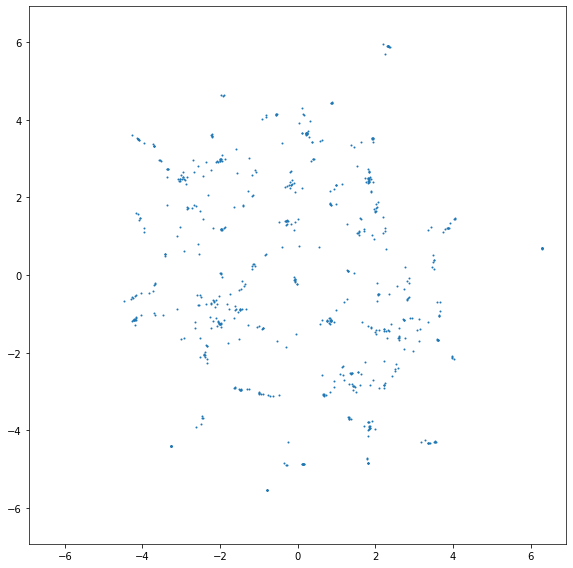

In [499]:
pymde.plot(gwps_viz_variable_embedding)

In [500]:
gwps_viz_variable_embedding.to_csv('20240331_fibroblast_embedding_coordinates.csv')

# Labeled figure

In [513]:
import re

def extract_id_and_genes(cluster_label):
    # Extract cluster ID
    cluster_id = re.search(r'^(\d+):', cluster_label).group(1)
    # Extract gene names
    genes = re.findall(r'\b([A-Z0-9-]+)\(\d+\)', cluster_label)
    # Join gene names with forward slash
    joined_genes = '/'.join(genes)
    return cluster_id, joined_genes

manual_clusters = gwps_mean_pop.cells.loc[masked_gwps_expr.index]['stricter_masked_cluster_description']
multi_manual_clusters = manual_clusters[manual_clusters.str.contains('multi')]
mapper = pd.Series({int(cid): genes for cid, genes in [extract_id_and_genes(label) for label in multi_manual_clusters]})

manual_clusters = gwps_mean_pop.cells.loc[masked_gwps_expr.index]['stricter_masked_cluster'].astype(int).map(mapper)


In [514]:
from collections import defaultdict
cluster_coords = defaultdict(dict)

for cluster in manual_clusters.dropna().unique():
    print(cluster)
    perturbations = manual_clusters[manual_clusters==cluster].index
    embx = table.loc[perturbations, 'x'].median()
    emby = table.loc[perturbations, 'y'].median()
    
    cluster_coords[cluster]['x'] = embx
    cluster_coords[cluster]['y'] = emby
    
cluster_coords = pd.DataFrame(cluster_coords).T
clustered_genes = '/'.join(manual_clusters.dropna().unique()).split('/')

BARX1/BSX/GSX2/MNX1
BCL11A/BCL11B
BID/GLIS3/ZFP36L2
BNC1/BNC2
CEBPA/CEBPB
CEBPB/HOXC11
CREBBP/EP300
DLX2/DLX3
EGR2/EGR3
EOMES/TBX21
ESX1/TLX1/VENTX
ETS1/FLI1
FOXD1/FOXD2/FOXD3
FOXF1/FOXF2
GATA2/GATA3
GATA4/GATA6
HMX3/NKX6-2
KLF3/KLF8
LHX2/LHX9/PDX1
MECOM/PRDM16
NEUROD1/NEUROD2
NKX3-1/NKX3-2
OVOL1/OVOL2
PAX2/PAX5
PHOX2A/ZBTB10
SALL1/SALL3
SOX17/SOX18
SOX8/SOX9
TBX15/TBX18
TFAP2A/TFAP2C/TFAP2E


In [515]:
strongest_guides = gwps_mean_pop.cells.query('primary_guide').sort_values('de_genes').tail(100).index
strongest_guide_names = strongest_guides.map(lambda x: x.split('_')[0])
strongest_guides = pd.Series(strongest_guides, index=strongest_guide_names)

strong_genes_to_add = strongest_guides.loc[np.setdiff1d(strongest_guide_names, clustered_genes)]

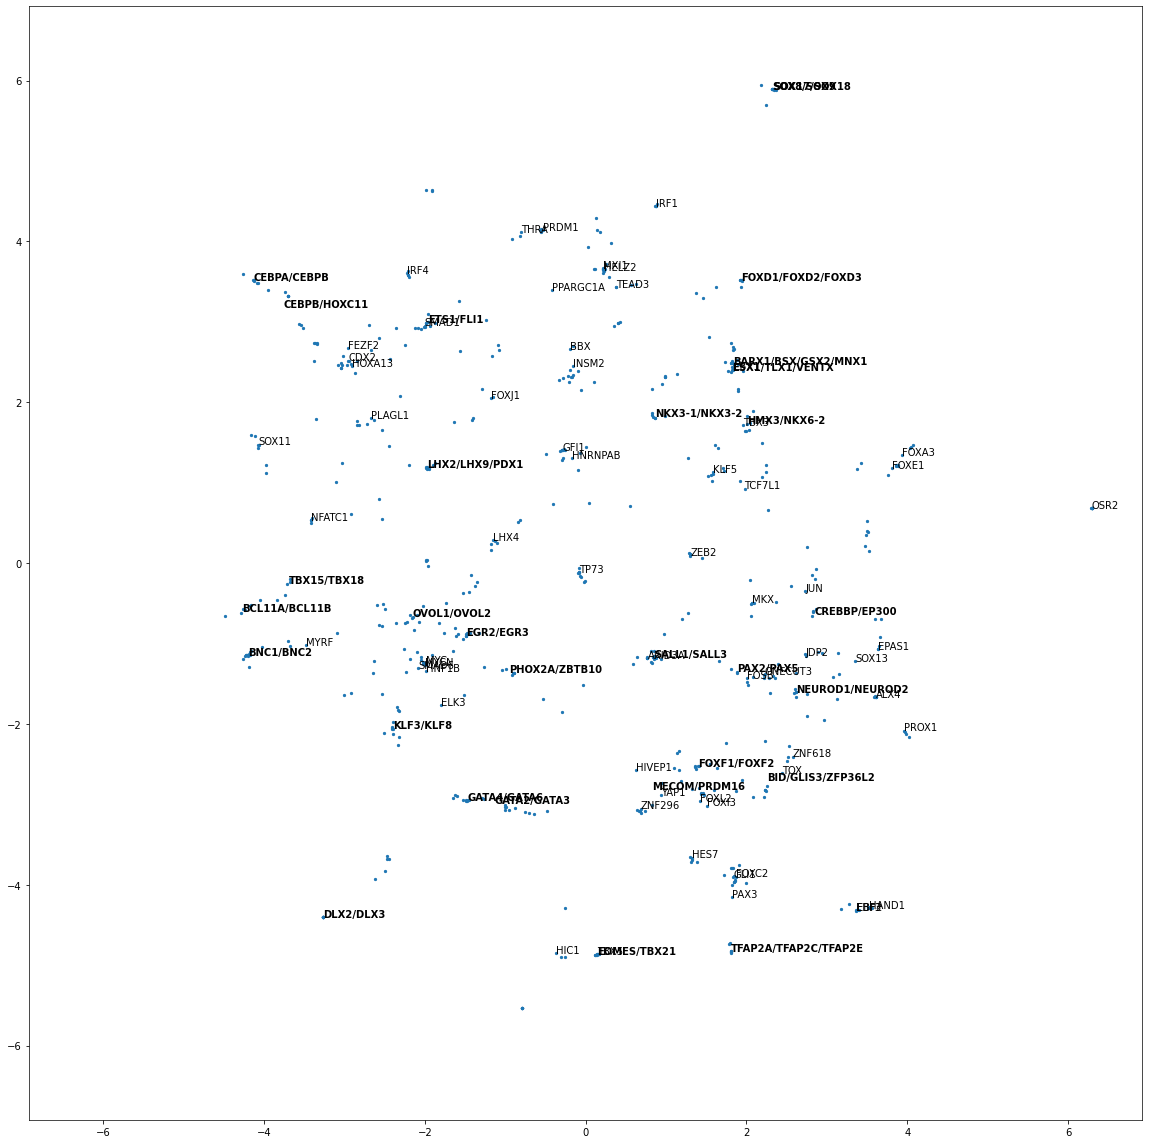

In [516]:
pymde.plot(gwps_viz_variable_embedding, marker_size=5, figsize_inches=[16,16])
ax = plt.gca()
for name, row in cluster_coords.iterrows():
    ax.annotate(name, row[['x', 'y']], fontweight='bold')
    

for name in strong_genes_to_add:
    ax.annotate(name.split('_')[0], table.loc[name, ['x', 'y']])